In [26]:
from web3 import Web3
import pandas as pd
from indexing_functions import * #indexing_functions.py
from configparser import ConfigParser
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio


config = ConfigParser()
config.read('../config.ini')
etherscan_api = str(config.get('ETHERSCAN','etherscan_api'))

In [27]:
# List of contracts. Must be in array format, even if there's only one contract
chain_list = {
    'Ethereum': {
        'uniswap_v3': ['0xE592427A0AEce92De3Edee1F18E0157C05861564' \
                       ,'0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45'] #SwapRouter +SwapRouter2
        ,'erc20': ['0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'] #USDC
    }
    ,'Arbitrum': {
        'uniswap_v3': ['0xE592427A0AEce92De3Edee1F18E0157C05861564' \
                       ,'0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45'] #SwapRouter +SwapRouter2
        ,'erc20': ['0xff970a61a04b1ca14834a43f5de4533ebddb5cc8'] #USDC
    }
    ,'Optimism': {
        'uniswap_v3': ['0xE592427A0AEce92De3Edee1F18E0157C05861564' \
                       ,'0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45'] #SwapRouter +SwapRouter2
        ,'erc20': ['0x7f5c764cbc14f9669b88837ca1490cca17c31607'], #USDC
    }
}

In [28]:
print(chain_list)

{'Ethereum': {'uniswap_v3': ['0xE592427A0AEce92De3Edee1F18E0157C05861564', '0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45'], 'erc20': ['0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48']}, 'Arbitrum': {'uniswap_v3': ['0xE592427A0AEce92De3Edee1F18E0157C05861564', '0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45'], 'erc20': ['0xff970a61a04b1ca14834a43f5de4533ebddb5cc8']}, 'Optimism': {'uniswap_v3': ['0xE592427A0AEce92De3Edee1F18E0157C05861564', '0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45'], 'erc20': ['0x7f5c764cbc14f9669b88837ca1490cca17c31607']}}


In [29]:
#print(chain_list)
chain_blocktimes = pd.DataFrame()
chain_transaction_data = pd.DataFrame()

for chain in chain_list:
    #set the right endpoint
    endpoint = config.get('ENDPOINTS',str.lower(chain))
    w3 = Web3(Web3.HTTPProvider(endpoint))
    temp_txs = pd.DataFrame()
    #get time range - last 24 hours
    end_blocktime = datetime.fromtimestamp( int(get_latest_block_info(chain)['result']['timestamp'], base =16) )
    start_blocktime =  end_blocktime - timedelta(hours = 72)
    # convert time range to block range
    end_block_number = int(get_latest_block(chain), base=16)
    start_block_number = get_block_by_timestamp(round(start_blocktime.timestamp()), chain)
    #Iterate through chains
    for contract in chain_list[chain]:
        contract_array_len = len(chain_list[chain][contract])
        print(chain)
        for i in range(contract_array_len):
            
            input_contract = chain_list[chain][contract][i]
            print(input_contract)
            result_txs = get_address_transactions_by_block_range(start_block_number,end_block_number,input_contract, chain)
            temp_txs = pd.DataFrame(result_txs)
            
            temp_txs = temp_txs[temp_txs['txreceipt_status'] == '1'] #only finalized txs
            
            # grab erc20 transfers only - by methodid
            if contract == 'erc20': 
                    temp_txs = temp_txs[temp_txs['input'].str[0:10] == '0xa9059cbb']

            transactions = pd.DataFrame(temp_txs[['hash','timeStamp']])
            # assign group segments
            transactions['chain'] = chain
            transactions['tx_type'] = contract
        #iterrate to calculate transaction fees
        # Ethereum: Etherscan gas price x gas used
        # L2s - Need to call web3 since there are specialized fields
            for index, row in transactions.iterrows(): 
                if chain == 'Ethereum':
                    transactions.loc[index, 'tx_fee'] = \
                        pd.to_numeric(temp_txs.loc[index,'gasPrice']) * pd.to_numeric(temp_txs.loc[index,'gas'])
                else:
                    tx_receipt = w3.eth.get_transaction_receipt(row['hash'])
                    gas_price = w3.eth.get_transaction(row['hash'])['gasPrice']
                    if chain == 'Optimism':
                        tx_fee = Web3.toInt(hexstr=tx_receipt['l1Fee']) +\
                                        tx_receipt['gasUsed'] * gas_price
                    elif chain == 'Arbitrum':
                        tx_fee = tx_receipt['effectiveGasPrice']*tx_receipt['gasUsed']
                    # Assign tx fee back to transactions
                    transactions.loc[index, 'tx_fee'] = tx_fee
           
        #print(transactions)    
        chain_transaction_data = chain_transaction_data.append(transactions)


Ethereum
0xE592427A0AEce92De3Edee1F18E0157C05861564
0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45
Ethereum
0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
Arbitrum
0xE592427A0AEce92De3Edee1F18E0157C05861564
0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45
Arbitrum
0xff970a61a04b1ca14834a43f5de4533ebddb5cc8
Optimism
0xE592427A0AEce92De3Edee1F18E0157C05861564
0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45
Optimism
0x7f5c764cbc14f9669b88837ca1490cca17c31607


In [30]:
print(chain_transaction_data)
chain_transaction_data.to_csv('t24h_tx_fees.csv')

                                                   hash   timeStamp     chain  \
0     0x244731d9c9232bc1d91e03d26d8f3f5bd68ced9247ef...  1642446524  Ethereum   
1     0xcd7893ea9f6e914cce86a5f3cf52109b77a1592d287b...  1642446524  Ethereum   
2     0x89173a48bec474c3578fbac7b0e69168306fed195c61...  1642446524  Ethereum   
3     0x7b01ea6ca82bb92ebdfef2d706fc1bf2992ec33509a7...  1642446500  Ethereum   
4     0x60dd255dcaf8144cd9cd75ec477c160499401de58b78...  1642446500  Ethereum   
...                                                 ...         ...       ...   
939   0xbc851a23a5ddb3048a81e44fe040cfafe77c0990ad2a...  1642228505  Optimism   
945   0x8f5bc82fa54ed110d0da2f6d94a7b125a254e067a10f...  1642227390  Optimism   
946   0x153f9266f2f9ed3a862f7f5cf8730683bb1cfc1a7a19...  1642227132  Optimism   
1001  0x5ac1bf680b157ffe4618c32db3768a7e6f6438c2baa7...  1642207809  Optimism   
1005  0xe764da30f86fbfeb7a52a298d8fbbd1b768954feea6b...  1642205837  Optimism   

         tx_type        tx_

In [31]:
chain_transaction_data['datetime'] = pd.to_datetime(chain_transaction_data['timeStamp'], unit = 's')
chain_transaction_data['tx_fee_eth'] = chain_transaction_data['tx_fee']/1e18
print(chain_transaction_data)                                             

                                                   hash   timeStamp     chain  \
0     0x244731d9c9232bc1d91e03d26d8f3f5bd68ced9247ef...  1642446524  Ethereum   
1     0xcd7893ea9f6e914cce86a5f3cf52109b77a1592d287b...  1642446524  Ethereum   
2     0x89173a48bec474c3578fbac7b0e69168306fed195c61...  1642446524  Ethereum   
3     0x7b01ea6ca82bb92ebdfef2d706fc1bf2992ec33509a7...  1642446500  Ethereum   
4     0x60dd255dcaf8144cd9cd75ec477c160499401de58b78...  1642446500  Ethereum   
...                                                 ...         ...       ...   
939   0xbc851a23a5ddb3048a81e44fe040cfafe77c0990ad2a...  1642228505  Optimism   
945   0x8f5bc82fa54ed110d0da2f6d94a7b125a254e067a10f...  1642227390  Optimism   
946   0x153f9266f2f9ed3a862f7f5cf8730683bb1cfc1a7a19...  1642227132  Optimism   
1001  0x5ac1bf680b157ffe4618c32db3768a7e6f6438c2baa7...  1642207809  Optimism   
1005  0xe764da30f86fbfeb7a52a298d8fbbd1b768954feea6b...  1642205837  Optimism   

         tx_type        tx_

In [32]:
eth_api = 'https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd' #coingecko
eth_price = requests.get(eth_api,headers=headers).json()['ethereum']['usd']

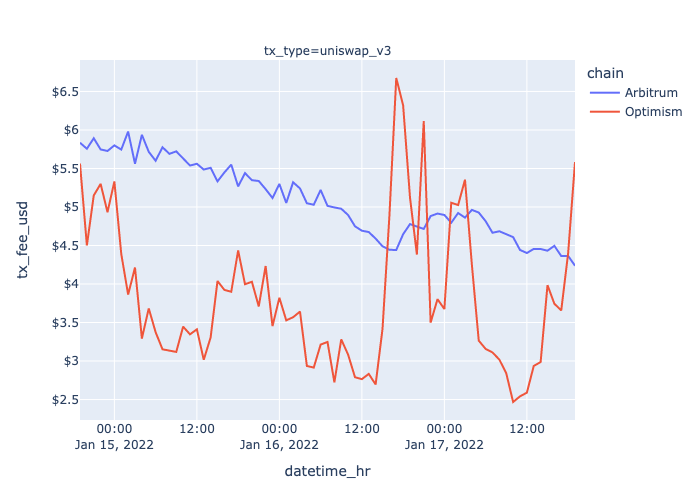

In [33]:
agg_fees = chain_transaction_data #copy
agg_fees['chain_tx_type'] = agg_fees['chain'] + ': ' + agg_fees['tx_type']
agg_fees['datetime_hr'] = agg_fees['datetime'].dt.floor('h')
agg_fees = agg_fees[['chain','tx_type','datetime_hr','tx_fee_eth']]
agg_fees = agg_fees.groupby( ['chain','tx_type','datetime_hr'] ).mean().reset_index()
agg_fees['tx_fee_usd'] = agg_fees['tx_fee_eth']*eth_price
# agg_fees = agg_fees[['chain', 'tx_type','datetime_hr','tx_fee_eth']]
# agg_fees = agg_fees.pivot(index = 'datetime_hr', columns = ["chain","tx_type"], values = 'tx_fee_eth')

agg_fees = agg_fees[agg_fees['chain'] != 'Ethereum']
swap_agg_fees = agg_fees[agg_fees['tx_type'] == 'uniswap_v3']

#at current eth price
fig = px.line(swap_agg_fees, x="datetime_hr", y="tx_fee_usd", color='chain', facet_col='tx_type')
fig.update_traces(hovertemplate=None)
fig.update_layout(yaxis_tickprefix = '$', hovermode='x')
fig.show()
fig.show("png")

#agg_fees = agg_fees[['tx_fee_eth']]
#agg_fees.plot()